<a href="https://colab.research.google.com/github/SriVinayA/SJSU-CMPE258-DeepLearning/blob/main/part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12828177.03it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 346384.04it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3226553.42it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10319896.41it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# neural network architecture

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# Supervised Contrastive Learning loss

In [ ]:
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        # Normalize features
        features = nn.functional.normalize(features, dim=1)

        # Compute similarities
        similarity_matrix = torch.matmul(features, features.T)

        # Create mask for positive samples
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float()

        # Compute logits
        logits = similarity_matrix / self.temperature
        exp_logits = torch.exp(logits) * (1 - torch.eye(labels.size(0), device=device))

        # Compute log_prob
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # Compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # Loss
        loss = -mean_log_prob_pos
        loss = loss.mean()

        return loss

# Softmax Classification Training

In [ ]:
def train_softmax(model, train_loader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Supervised Contrastive Learning Training

In [ ]:
def train_scl(model, train_loader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass to get embeddings
            features = model(images)

            # Compute contrastive loss
            loss = criterion(features, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Embedding Visualization

In [ ]:
def visualize_embeddings(model, loader, title):
    model.eval()
    with torch.no_grad():
        embeddings = []
        labels_list = []

        for images, labels in loader:
            images = images.to(device)
            features = model(images)
            embeddings.append(features.cpu().numpy())
            labels_list.append(labels.numpy())

        embeddings = np.concatenate(embeddings, axis=0)
        labels_list = np.concatenate(labels_list, axis=0)

        tsne = TSNE(n_components=2, random_state=123)
        embeddings_tsne = tsne.fit_transform(embeddings)

        plt.figure(figsize=(8, 8))
        scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels_list, cmap='tab10', alpha=0.6)
        plt.colorbar(scatter)
        plt.title(title)
        plt.show()

# Model and Loss Setup

In [ ]:
# Model setup
model_softmax = Net().to(device)
model_scl = Net().to(device)

# Optimizers
optimizer_softmax = optim.Adam(model_softmax.parameters(), lr=0.001)
optimizer_scl = optim.Adam(model_scl.parameters(), lr=0.001)

# Loss functions
criterion_softmax = nn.CrossEntropyLoss()
criterion_scl = SupConLoss().to(device)

# Training Execution

Training with Softmax Loss:
Epoch [1/10], Loss: 0.1746
Epoch [2/10], Loss: 0.0453
Epoch [3/10], Loss: 0.0333
Epoch [4/10], Loss: 0.0262
Epoch [5/10], Loss: 0.0192
Epoch [6/10], Loss: 0.0173
Epoch [7/10], Loss: 0.0130
Epoch [8/10], Loss: 0.0111
Epoch [9/10], Loss: 0.0109
Epoch [10/10], Loss: 0.0074
Training with Supervised Contrastive Loss:
Epoch [1/10], Loss: 2.7514
Epoch [2/10], Loss: 2.5900
Epoch [3/10], Loss: 2.5658
Epoch [4/10], Loss: 2.5473
Epoch [5/10], Loss: 2.5342
Epoch [6/10], Loss: 2.5254
Epoch [7/10], Loss: 2.5202
Epoch [8/10], Loss: 2.5115
Epoch [9/10], Loss: 2.5076
Epoch [10/10], Loss: 2.5054


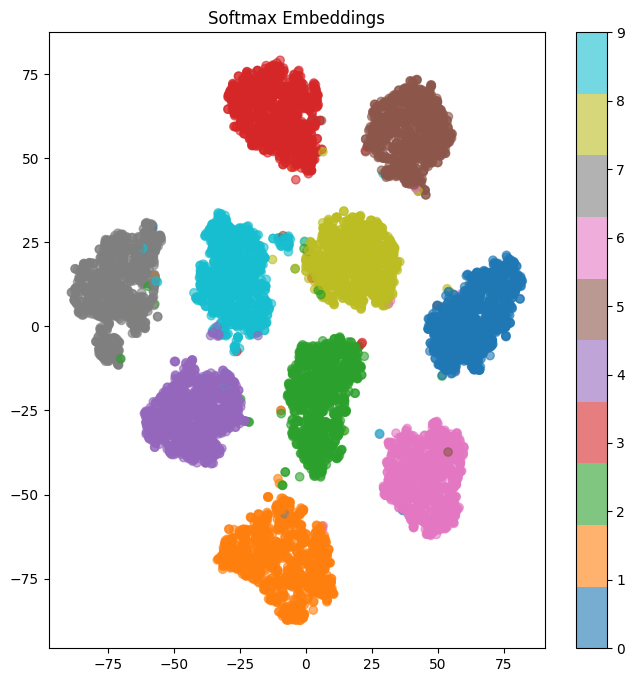

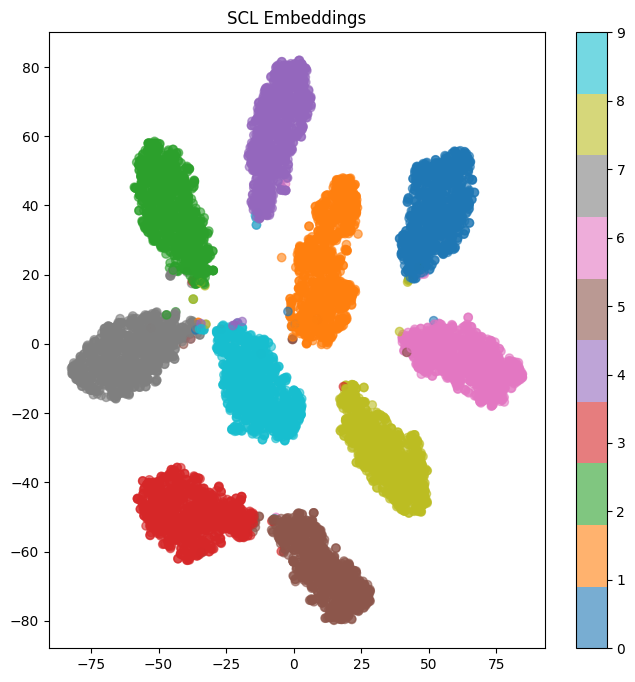

In [ ]:
# Train Softmax model
print("Training with Softmax Loss:")
train_softmax(model_softmax, train_loader, optimizer_softmax, criterion_softmax, epochs=10)

# Train SCL model
print("Training with Supervised Contrastive Loss:")
train_scl(model_scl, train_loader, optimizer_scl, criterion_scl, epochs=10)

# Visualize Embeddings
visualize_embeddings(model_softmax, test_loader, "Softmax Embeddings")
visualize_embeddings(model_scl, test_loader, "SCL Embeddings")